In [1]:
import pandas as pd
import numpy as np
import math
from pandas_datareader.data import DataReader
import pandas_datareader
from datetime import datetime as dt
import os
import matplotlib.pyplot as plt
from datetime import timedelta
import time
from pandas_datareader.moex import MoexReader
import datetime
from scipy.optimize import fsolve
from scipy.optimize import fmin, fmin_powell, basinhopping, differential_evolution, minimize
import warnings
from scipy.stats import t

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

/Users/denisbondarenko/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
trades_info = pd.read_excel('trades_info.xlsx', index_col=0)
lb_info = trades_info[(trades_info['%_of_days_traded'] > .9)].copy() # liquid bonds info - those taken in analysis
ratings = list(lb_info['rating'].unique())
issuers = pd.Series()
for rating in ratings:
    issuers = issuers.append(pd.read_excel(rating + '_bonds.xlsx')[['ISIN', 'Эмитент']].set_index('ISIN'))
del issuers[0]    
issuers.rename(columns = {'Эмитент':'Issuer'}, inplace = True)
lb_info = lb_info.merge(right = issuers, how = 'left', left_on = 'isin', right_index = True)
lb_info['Option'] = 0
lb_info.set_index('isin', inplace = True)
for isin in lb_info.index:
    q = pd.read_csv(os.getcwd() + '/Quotes/' + isin + '.csv')
    q.set_index('Trade date', inplace = True)
    q.sort_index(ascending = True, inplace = True)
    if q[pd.notna(q['Put/call date'])].shape[0] > 0: 
        lb_info['Option'][isin] = 1
lb_info.reset_index(inplace = True)
lb_info = lb_info[lb_info['Option'] == 0]
ratings = list(lb_info['rating'].unique())
ratings

['AAA', 'AA', 'A', 'BBB', 'BB', 'B']

In [4]:
def parser(s):
    if isinstance(s, float): return s
    s = s[1:-1]
    s = s.replace('\n', '')
    s = s.replace(',', '')
#     print(s)
    l = []
    num = ''
    for char in s:
        if char != ' ':
            num += char
        else:
            if len(num) != 0: 
#                 print(float(num))
                l += [float(num)]
#                 print(l)
                num = ''
    if num != '': l += [float(num)]
    return l
def t_stats(x): # x is a vector of values 
    m = x.mean() 
    s = x.std() 
    dof = len(x) - 1 
    confidence = 0.95
    t_crit = np.abs(t.ppf((1 - confidence) / 2, dof))
    return (np.round(m - s * t_crit / np.sqrt(len(x)), 2), np.round(m + s * t_crit / np.sqrt(len(x)), 2)) 

## Table 1.

In [346]:
ers = pd.DataFrame(columns = ratings, dtype = 'object')
rmse = pd.read_excel(os.getcwd()+'/Model1/rmse.xlsx', index_col = 0)
mae = pd.read_excel(os.getcwd()+'/Model1/mae.xlsx', index_col = 0)
ers = ers.append(np.round(rmse.mean(), 2), ignore_index = True)
ers = ers.append(rmse.apply(t_stats), ignore_index = True)
ers = ers.append(np.round(mae.mean(), 2), ignore_index = True)
ers = ers.append(mae.apply(t_stats), ignore_index = True)
ers.index = ['RMSE', '', 'MAE', '']
# ers.to_excel(os.getcwd()+'/Model1/error_stats.xlsx')
ers

,AAA,AA,A,BBB,BB,B
RMSE,1.41,2.64,1.56,1.53,0.74,0.55
,"(1.36, 1.45)","(2.23, 3.06)","(1.54, 1.58)","(1.07, 1.98)","(0.71, 0.77)","(0.52, 0.58)"
MAE,1.11,2,1.24,1.31,0.59,0.4
,"(1.09, 1.13)","(1.6, 2.4)","(1.23, 1.26)","(0.85, 1.76)","(0.56, 0.62)","(0.38, 0.43)"


## Table 2.

In [7]:
df = pd.read_excel(os.getcwd()+'/Model1/curves.xlsx', index_col=0)
for rating in ratings:
    df[rating] = df[rating].apply(parser)
cc = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    cc[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[4])
ba = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    ba[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[5])
sr_plus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    sr_plus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[6])
sr_minus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    sr_minus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[7])

In [9]:
coeffs = pd.DataFrame(columns = ratings, dtype = 'object')
coeffs = coeffs.append(np.round(sr_minus.mean(), 2), ignore_index = True)
coeffs = coeffs.append(sr_minus.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(sr_plus.mean(), 2), ignore_index = True)
coeffs = coeffs.append(sr_plus.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(cc.mean(), 2), ignore_index = True)
coeffs = coeffs.append(cc.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(ba.mean(), 2), ignore_index = True)
coeffs = coeffs.append(ba.apply(t_stats), ignore_index = True)
coeffs.index = ['SR-', '', 'SR+', '', 'Coupon', '', 'Bid-Ask', '']
coeffs['AAA']['SR+'] = 'NA'
coeffs['AAA']['SR-'] = 'NA'
# coeffs.to_excel(os.getcwd()+'/Model1/coeffs.xlsx')
coeffs

,AAA,AA,A,BBB,BB,B
SR-,NA,2.11,1.24,0.99,1.08,1.25
,"(7.99, 8.68)","(1.83, 2.39)","(1.19, 1.29)","(0.93, 1.05)","(0.99, 1.17)","(1.11, 1.39)"
SR+,NA,-0.01,0.33,-0.76,1.73,1.65
,"(7.99, 8.68)","(-0.11, 0.08)","(0.3, 0.35)","(-0.83, -0.7)","(1.67, 1.79)","(1.57, 1.73)"
Coupon,0.21,0.38,0.45,0.41,1.8,1.55
,"(0.2, 0.22)","(0.34, 0.42)","(0.44, 0.46)","(0.39, 0.44)","(1.66, 1.94)","(1.51, 1.59)"
Bid-Ask,-0.05,-0.75,-0.15,0.35,0.17,-1.24
,"(-0.08, -0.02)","(-0.92, -0.58)","(-0.23, -0.07)","(-0.01, 0.72)","(0.04, 0.3)","(-1.56, -0.92)"


## Table 3.

In [11]:
ers = pd.DataFrame(columns = ratings, dtype = 'object')
rmse = pd.read_excel(os.getcwd()+'/Model2/rmse.xlsx', index_col = 0)
mae = pd.read_excel(os.getcwd()+'/Model2/mae.xlsx', index_col = 0)
ers = ers.append(np.round(rmse.mean(), 2), ignore_index = True)
ers = ers.append(rmse.apply(t_stats), ignore_index = True)
ers = ers.append(np.round(mae.mean(), 2), ignore_index = True)
ers = ers.append(mae.apply(t_stats), ignore_index = True)
ers.index = ['RMSE', '', 'MAE', '']
# ers = ers[['AAA', 'AA', 'A', 'BBB', 'BB', 'B']]
# ers.to_excel(os.getcwd()+'/Model2/error_stats_no_option_v4.xlsx')
ers

,AAA,AA,A,BBB,BB,B
RMSE,1.63,2.39,1.54,0.98,0.74,0.54
,"(1.58, 1.67)","(2.25, 2.52)","(1.52, 1.57)","(0.94, 1.01)","(0.71, 0.77)","(0.51, 0.57)"
MAE,1.26,1.78,1.22,0.77,0.58,0.39
,"(1.24, 1.28)","(1.7, 1.86)","(1.21, 1.24)","(0.74, 0.8)","(0.56, 0.61)","(0.37, 0.42)"


## Table 4. 

In [12]:
df = pd.read_excel(os.getcwd()+'/Model2/curves.xlsx', index_col = 0)
for rating in ratings:
    df[rating] = df[rating].apply(parser)
cc = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    cc[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[4])
ba = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    ba[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[5])
sr_plus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    sr_plus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[6])
sr_minus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    sr_minus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[7])
gc = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    gc[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[8])


In [343]:
coeffs = pd.DataFrame(columns = ratings, dtype = 'object')
coeffs = coeffs.append(np.round(sr_minus.mean(), 2), ignore_index = True)
coeffs = coeffs.append(sr_minus.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(sr_plus.mean(), 2), ignore_index = True)
coeffs = coeffs.append(sr_plus.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(cc.mean(), 2), ignore_index = True)
coeffs = coeffs.append(cc.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(gc.mean(), 2), ignore_index = True)
coeffs = coeffs.append(gc.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(ba.mean(), 2), ignore_index = True)
coeffs = coeffs.append(ba.apply(t_stats), ignore_index = True)
coeffs.index = ['SR-', '', 'SR+', '', 'Coupon', '', 'Gov', '', 'Bid-Ask', '']
coeffs['BB']['Gov'] = 'NA'
coeffs['B']['Gov'] = 'NA'
coeffs['AAA']['SR+'] = 'NA'
coeffs['AAA']['SR-'] = 'NA'
# coeffs.to_excel(os.getcwd()+'/Model2/coeffs.xlsx')
coeffs

,AAA,AA,A,BBB,BB,B
SR-,NA,2.49,1.22,0.89,1.08,1.24
,"(5.48, 5.93)","(2.12, 2.87)","(1.17, 1.27)","(0.83, 0.94)","(0.98, 1.17)","(1.1, 1.38)"
SR+,NA,-0.18,0.3,-0.39,1.73,1.64
,"(5.48, 5.93)","(-0.29, -0.08)","(0.27, 0.33)","(-0.45, -0.32)","(1.67, 1.79)","(1.56, 1.72)"
Coupon,0.12,0.37,0.45,0.45,1.8,1.55
,"(0.11, 0.13)","(0.33, 0.4)","(0.44, 0.46)","(0.43, 0.48)","(1.66, 1.94)","(1.51, 1.59)"
Gov,0.86,-0.56,1.42,1.45,NA,NA
,"(0.83, 0.89)","(-0.63, -0.49)","(1.18, 1.66)","(1.37, 1.52)","(6.43, 7.57)","(9.12, 10.6)"
Bid-Ask,0.07,-0.88,-0.16,0.16,0.19,-1.26
,"(0.05, 0.1)","(-1.05, -0.71)","(-0.25, -0.08)","(-0.15, 0.47)","(0.05, 0.32)","(-1.58, -0.95)"


## Table 5. 

In [5]:
ers = pd.DataFrame(columns = ratings, dtype = 'object')
rmse = pd.read_excel(os.getcwd()+'/Model1/rmse_joint.xlsx', index_col = 0)
mae = pd.read_excel(os.getcwd()+'/Model1/mae_joint.xlsx', index_col = 0)
ers = ers.append(np.round(rmse.mean(), 2), ignore_index = True)
ers = ers.append(rmse.apply(t_stats), ignore_index = True)
ers = ers.append(np.round(mae.mean(), 2), ignore_index = True)
ers = ers.append(mae.apply(t_stats), ignore_index = True)
ers.index = ['RMSE', '', 'MAE', '']
# ers.to_excel(os.getcwd()+'/Model1/error_stats_joint.xlsx')
ers

,AAA,AA,A,BBB,BB,B
RMSE,1.31,2.39,1.47,1.48,0.54,0.48
,"(1.21, 1.41)","(2.23, 2.54)","(1.38, 1.55)","(1.02, 1.94)","(0.45, 0.64)","(0.39, 0.57)"
MAE,1.02,1.72,1.09,1.24,0.48,0.36
,"(0.93, 1.11)","(1.6, 1.84)","(1.0, 1.18)","(0.78, 1.7)","(0.39, 0.57)","(0.27, 0.45)"


## Table 6. 

In [16]:
df = pd.read_excel(os.getcwd()+'/Model1/curves_joint.xlsx', index_col=0)
for rating in ratings:
    df[rating] = df[rating].apply(parser)
cc = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    cc[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[4])
ba = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    ba[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[5])
sr_plus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    sr_plus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[6])
sr_minus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    sr_minus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[7])

In [17]:
coeffs = pd.DataFrame(columns = ratings, dtype = 'object')
coeffs = coeffs.append(np.round(sr_minus.mean(), 2), ignore_index = True)
coeffs = coeffs.append(sr_minus.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(sr_plus.mean(), 2), ignore_index = True)
coeffs = coeffs.append(sr_plus.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(cc.mean(), 2), ignore_index = True)
coeffs = coeffs.append(cc.apply(t_stats), ignore_index = True)
coeffs = coeffs.append(np.round(ba.mean(), 2), ignore_index = True)
coeffs = coeffs.append(ba.apply(t_stats), ignore_index = True)
coeffs.index = ['SR-', '', 'SR+', '', 'Coupon', '', 'Bid-Ask', '']
coeffs['AAA']['SR+'] = 'NA'
coeffs['AAA']['SR-'] = 'NA'
# coeffs.to_excel(os.getcwd()+'/Model1/coeffs_joint.xlsx')
coeffs

,AAA,AA,A,BBB,BB,B
SR-,NA,1.15,1.46,0.98,1.08,1.25
,"(7.6, 8.32)","(0.96, 1.34)","(1.42, 1.51)","(0.92, 1.04)","(0.98, 1.17)","(1.11, 1.4)"
SR+,NA,-0.17,0.6,-0.84,1.67,1.6
,"(4.01, 4.97)","(-0.29, -0.06)","(0.55, 0.65)","(-0.92, -0.76)","(1.6, 1.74)","(1.51, 1.7)"
Coupon,0.22,0.38,0.43,0.41,1.79,1.54
,"(0.21, 0.23)","(0.34, 0.42)","(0.41, 0.45)","(0.38, 0.43)","(1.65, 1.93)","(1.5, 1.58)"
Bid-Ask,-0.08,-0.89,-0.45,0.31,0.12,-1.28
,"(-0.11, -0.06)","(-1.08, -0.71)","(-0.55, -0.36)","(-0.06, 0.67)","(-0.01, 0.25)","(-1.6, -0.97)"


## Figure 1.

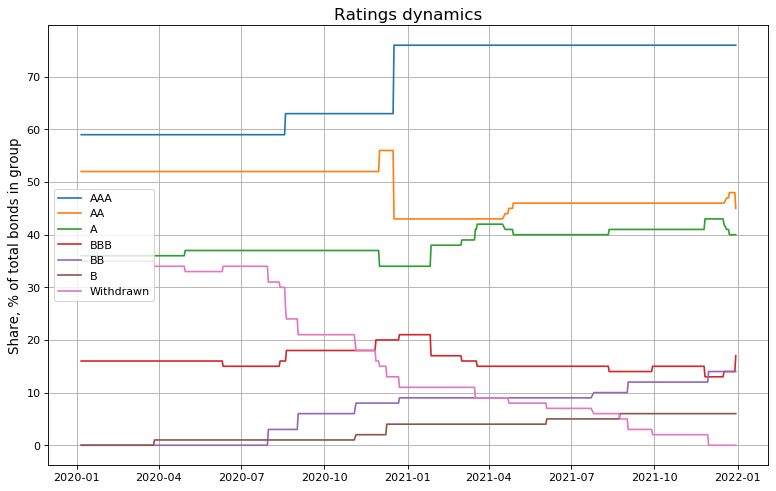

In [6]:
ratings_info = pd.read_excel(os.getcwd() + '/Inputs_for_modelling/ratings_info.xlsx', index_col = 0)
rd = ratings_info.apply(lambda x: x.value_counts(), axis = 1).fillna(0)
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Ratings dynamics', y=1.04, fontsize=15)
# axes1 = fig.add_subplot(211)
axes = fig.add_axes([0, 0, 1, 1])
axes.grid()
for rating in ratings:
    axes.plot(rd[rating], label = rating)
axes.plot(rd['Withdraw'], label = 'Withdrawn')
# axes.set(xlabel = 'Date', ylabel = 'Share')
axes.set_ylabel('Share, % of total bonds in group', fontsize=12)
# axes.plot(rd)
axes.legend(loc = 6)

## Figure 2.

In [7]:
ytms = pd.DataFrame(index = rmse.index, columns = lb_info['isin'].values, dtype = 'object')
ttms = pd.DataFrame(index = rmse.index, columns = lb_info['isin'].values, dtype = 'object')
lb_info['Maturity'] = np.nan
lb_info.set_index('isin', inplace = True)
for isin in ytms.columns:
    q = pd.read_csv(os.getcwd() + '/Quotes/' + isin + '.csv')
    q.set_index('Trade date', inplace = True)
    q.sort_index(ascending = True, inplace = True)
    lb_info['Maturity'][isin] = q['Maturity date'].values[0]
#     q[]
    for date, row in q.iterrows():
        ytms[isin][date] = row['YTM (close), %']
        ttms[isin][date] = row['Duration'] / 365
    
#     display(q.head(2))
lb_info.reset_index(inplace = True)
lb_info['Maturity'] = pd.to_datetime(lb_info['Maturity'], format = '%Y-%m-%d')


Text(0.5, 0, 'Ratings')

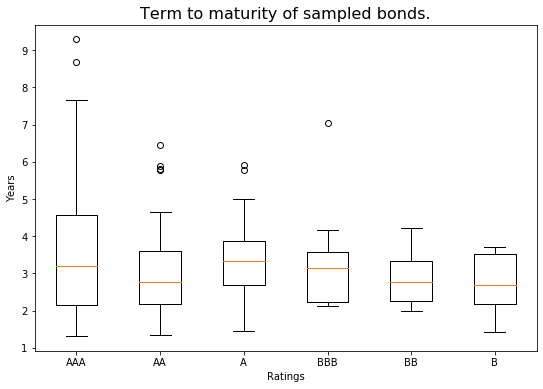

In [8]:
ratings = lb_info['rating'].unique()
lb_info['ttm'] = (lb_info['Maturity'] - dt.strptime('2020-08-26', '%Y-%m-%d')) / timedelta(days = 365)
fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.set_title('Term to maturity of sampled bonds.', fontsize=16)
list_ttm = [lb_info[lb_info['rating'] == rating]['ttm'] for rating in ratings]
# ax1.boxplot(list_ttm, labels = ratings, showfliers=False)
ax1.boxplot(list_ttm, labels = ratings)
ax1.set_ylabel('Years')
ax1.set_xlabel('Ratings')

## Figure 3.

Text(0.5, 0.98, 'Sample bonds YTMs.')

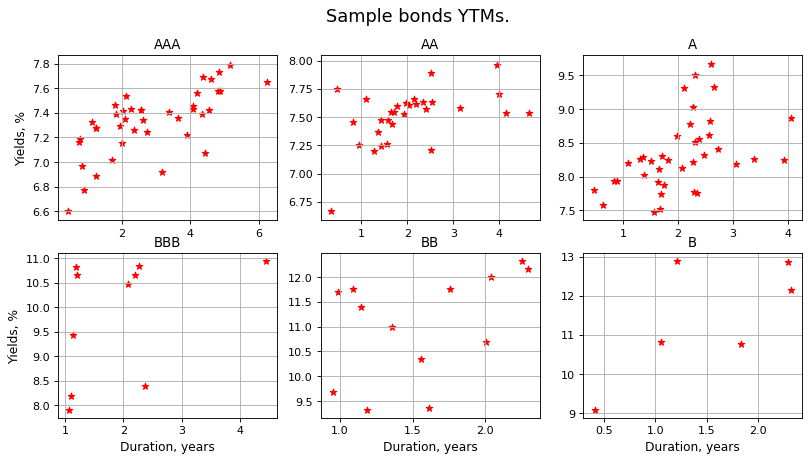

In [9]:
date = '2021-08-26'
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6), dpi=80)
isins = list(lb_info[lb_info['rating'] == 'AAA']['isin'].values)
axes[0, 0].scatter(ttms.loc[date][isins], ytms.loc[date][isins], ls='None', marker='*', color='red')
isins = list(lb_info[lb_info['rating'] == 'AA']['isin'].values)
axes[0, 1].scatter(ttms.loc[date][isins], ytms.loc[date][isins], ls='None', marker='*', color='red')
isins = list(lb_info[lb_info['rating'] == 'A']['isin'].values)
axes[0, 2].scatter(ttms.loc[date][isins], ytms.loc[date][isins], ls='None', marker='*', color='red')
isins = list(lb_info[lb_info['rating'] == 'BBB']['isin'].values)
axes[1, 0].scatter(ttms.loc[date][isins], ytms.loc[date][isins], ls='None', marker='*', color='red')
isins = list(lb_info[lb_info['rating'] == 'BB']['isin'].values)
axes[1, 1].scatter(ttms.loc[date][isins], ytms.loc[date][isins], ls='None', marker='*', color='red')
isins = list(lb_info[lb_info['rating'] == 'B']['isin'].values)
axes[1, 2].scatter(ttms.loc[date][isins], ytms.loc[date][isins], ls='None', marker='*', color='red')
axes[0, 0].grid()
axes[0, 1].grid()
axes[0, 2].grid()
axes[1, 0].grid()
axes[1, 1].grid()
axes[1, 2].grid()
# axes[0, 0].legend()
# axes[0, 1].legend()
# axes[1, 0].legend()
# axes[1, 1].legend()
# axes[2, 0].legend()
# axes[2, 1].legend()
axes[0, 0].set_title('AAA')
axes[0, 1].set_title('AA')
axes[0, 2].set_title('A')
axes[1, 0].set_title('BBB')
axes[1, 1].set_title('BB')
axes[1, 2].set_title('B')
axes[0, 0].set_ylabel('Yields, %', fontsize = 11)
axes[1, 0].set_ylabel('Yields, %', fontsize = 11)
axes[1, 0].set_xlabel('Duration, years', fontsize = 11)
axes[1, 1].set_xlabel('Duration, years', fontsize = 11)
axes[1, 2].set_xlabel('Duration, years', fontsize = 11)
fig.suptitle('Sample bonds YTMs.', y=.98, fontsize=16)

# Figure 4.

In [10]:
ratings_info = pd.read_excel(os.getcwd() + '/Inputs_for_modelling/ratings_info.xlsx', index_col = 0)
subratings_info = pd.read_excel(os.getcwd() + '/Inputs_for_modelling/subratings_info.xlsx', index_col = 0)
state_flags = pd.read_excel(os.getcwd() + '/Inputs_for_modelling/state_flags.xlsx', index_col = 0)
quotes = pd.read_csv(os.getcwd() + '/Inputs_for_modelling/quotes_vars.csv', index_col = 0)
quotes.reset_index(inplace = True)
quotes['TRADEDATE'] = pd.to_datetime(quotes['TRADEDATE'], format = '%Y-%m-%d')
quotes.set_index('TRADEDATE', inplace = True)
plus_info = pd.DataFrame(index = rmse.index, columns = ratings, dtype = 'object')
minus_info = pd.DataFrame(index = rmse.index, columns = ratings, dtype = 'object')
ba_info = pd.DataFrame(index = rmse.index, columns = ratings, dtype = 'object')
gf_info = pd.DataFrame(index = rmse.index, columns = ratings, dtype = 'object')
for date in plus_info.index:
    for rating in ratings:
        isins = ratings_info.loc[date][ratings_info.loc[date] == rating].index
        plus_info[rating][date] = len(subratings_info.loc[date][isins][subratings_info.loc[date][isins] == '+'])
        minus_info[rating][date] = len(subratings_info.loc[date][isins][subratings_info.loc[date][isins] == '-'])
        ba_info[rating][date] = quotes.loc[date][isins].mean()
        gf_info[rating][date] = state_flags['Flag'][isins].sum()
gf_info

,AAA,AA,A,BBB,BB,B
TRADEDATE,,,,,,
2020-01-06,53,19,3,4,0,0
2020-01-08,53,19,3,4,0,0
2020-01-09,53,19,3,4,0,0
2020-01-10,53,19,3,4,0,0
2020-01-13,53,19,3,4,0,0
...,...,...,...,...,...,...
2021-12-24,57,20,3,4,0,0
2021-12-27,57,20,3,4,0,0
2021-12-28,57,20,3,4,0,0


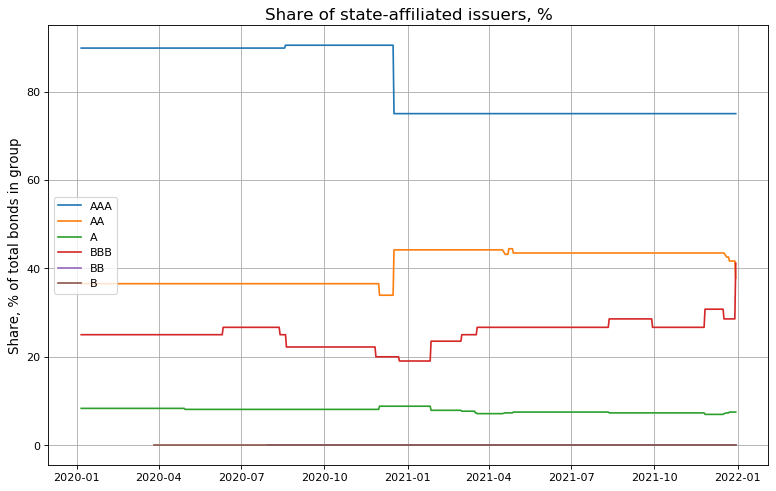

In [11]:
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Share of state-affiliated issuers, %', y=1.04, fontsize=15)

axes = fig.add_axes([0, 0, 1, 1])
axes.grid()

for rating in ratings:
    axes.plot((gf_info[rating][rd[rating] != 0] / rd[rating][rd[rating] != 0]) * 100, label = rating)

axes.set_ylabel('Share, % of total bonds in group', fontsize=12)
axes.legend(loc = 6)

## Figures 5. - 7.

In [27]:
df = pd.read_excel(os.getcwd()+'/Model1/curves.xlsx', index_col=0)
for rating in ratings:
    df[rating] = df[rating].apply(parser)
taus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    taus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[0])
b2 = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    b2[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[3])
s0 = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
for rating in ratings:
    s0[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[1] + x[2])
# sr_minus = pd.DataFrame(index = df.index, columns = df.columns, dtype = 'object')
# for rating in ratings:
#     sr_minus[rating] = df[rating].apply(lambda x: np.nan if isinstance(x, float) else x[7])

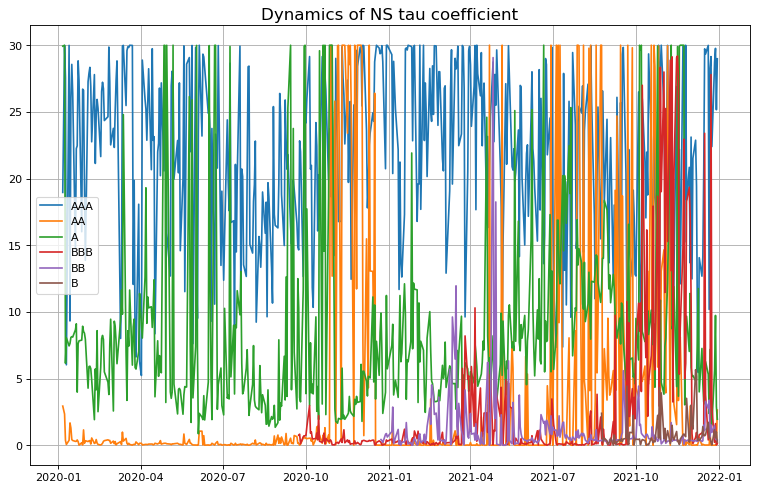

In [28]:
# Figure 5
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Dynamics of NS tau coefficient', y=1.04, fontsize=15)

axes = fig.add_axes([0, 0, 1, 1])
axes.grid()

for rating in ratings:
#     print(rating)
    axes.plot(taus[pd.notna(taus[rating])][rating], label = rating)

axes.legend(loc = 6)

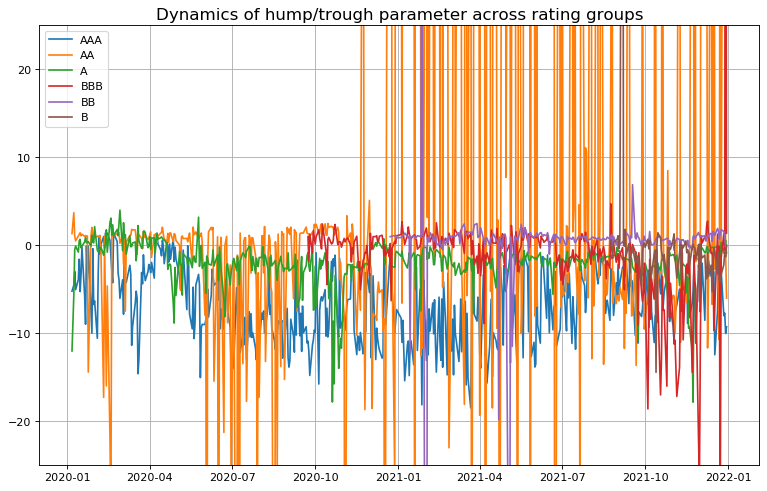

In [29]:
# Figure 6
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Dynamics of hump/trough parameter across rating groups', y=1.04, fontsize=15)

axes = fig.add_axes([0, 0, 1, 1])
axes.grid()

for rating in ratings:
#     print(rating)
    axes.plot(b2[pd.notna(b2[rating])][rating], label = rating)

axes.set_ylim((-25, 25))
axes.legend(loc = 0)

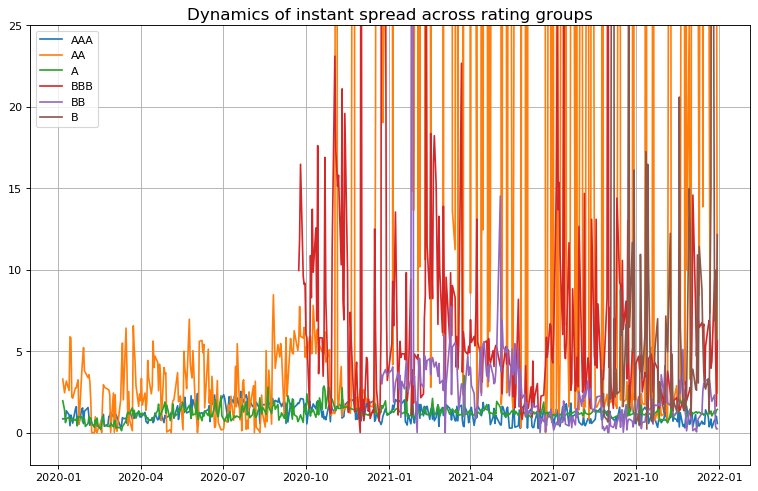

In [30]:
# Figure 7
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Dynamics of instant spread across rating groups', y=1.04, fontsize=15)

axes = fig.add_axes([0, 0, 1, 1])
axes.grid()

for rating in ratings:
#     print(rating)
    axes.plot(s0[pd.notna(s0[rating])][rating], label = rating)

axes.set_ylim((-2, 25))
axes.legend(loc = 0)

# Attachments

## Attachment 1

Text(0, 0.5, 'Share, % of total bonds in group')

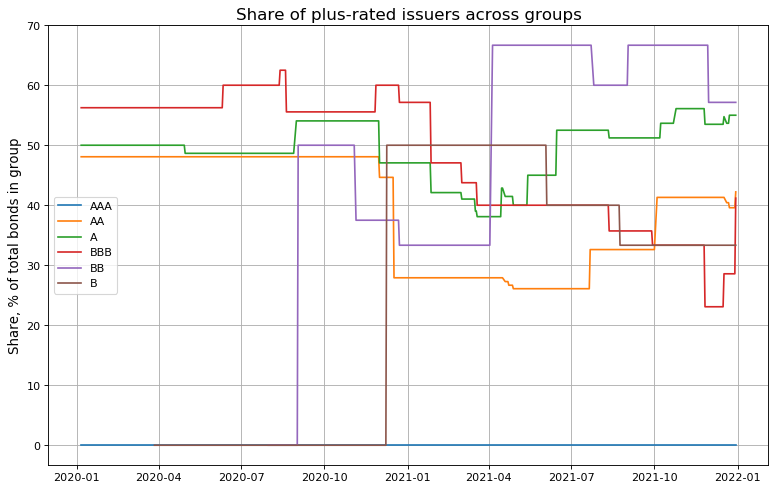

In [12]:
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Share of plus-rated issuers across groups', y=1.04, fontsize=15)

axes = fig.add_axes([0, 0, 1, 1])
axes.grid()

for rating in ratings:
    axes.plot((plus_info[rating][rd[rating] != 0] / rd[rating][rd[rating] != 0]) * 100, label = rating)

axes.legend(loc = 6)
axes.set_ylabel('Share, % of total bonds in group', fontsize=12)

## Attachment 2

Text(0, 0.5, 'Share, % of total bonds in group')

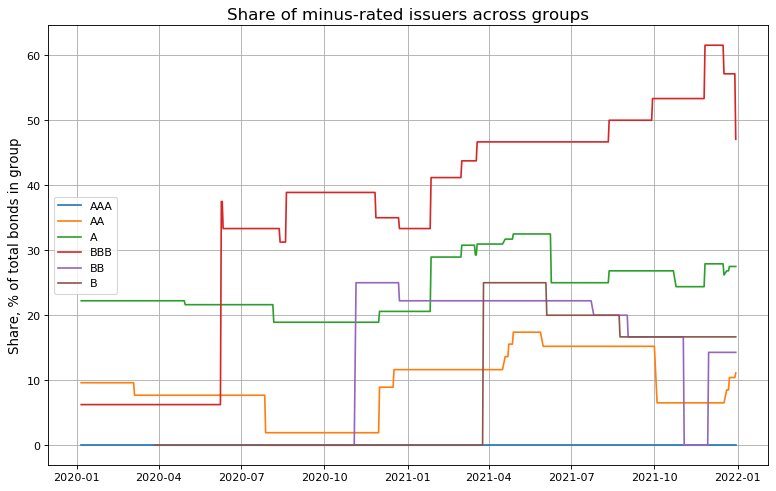

In [13]:
fig = plt.figure( figsize=(9,5.5), dpi=80, facecolor='w', edgecolor='k')
fig.suptitle('Share of minus-rated issuers across groups', y=1.04, fontsize=15)

axes = fig.add_axes([0, 0, 1, 1])
axes.grid()

for rating in ratings:
    axes.plot((minus_info[rating][rd[rating] != 0] / rd[rating][rd[rating] != 0]) * 100, label = rating)

axes.legend(loc = 6)
axes.set_ylabel('Share, % of total bonds in group', fontsize=12)